In [130]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [131]:
data = pd.read_csv('finaldataset.csv')
data.head()

,Unnamed: 0,Date,Time,NOx.GT.,CO.GT.,T,RH,AH
0,7,11/03/2004,00.00.00,62.000000,1.200000,11.3,56.8,0.7603
1,8,11/03/2004,01.00.00,62.000000,1.000000,10.7,60.0,0.7702
2,9,11/03/2004,02.00.00,45.000000,0.900000,10.7,59.7,0.7648
3,10,11/03/2004,03.00.00,149.260174,0.600000,10.3,60.2,0.7517
4,11,11/03/2004,04.00.00,21.000000,-8.024299,10.1,60.5,0.7465


In [132]:
NOx = data['NOx.GT.']

In [133]:
train = data[data.Date.str.endswith('03/2004')]

In [134]:
train = train['NOx.GT.']

In [135]:
test = data[data.Date == '01/04/2004']

In [136]:
test = test['NOx.GT.']

<Axes: ylabel='NOx.GT.'>

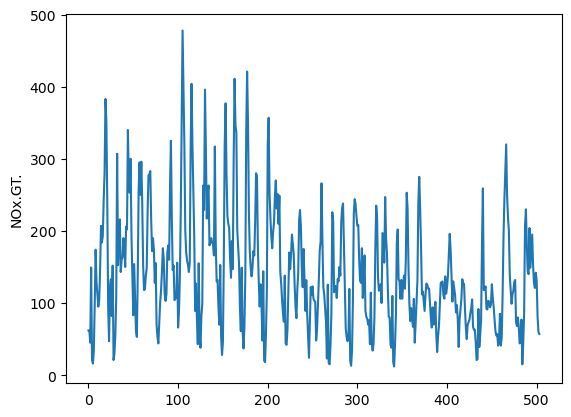

In [137]:
sns.lineplot(train)

<Axes: ylabel='NOx.GT.'>

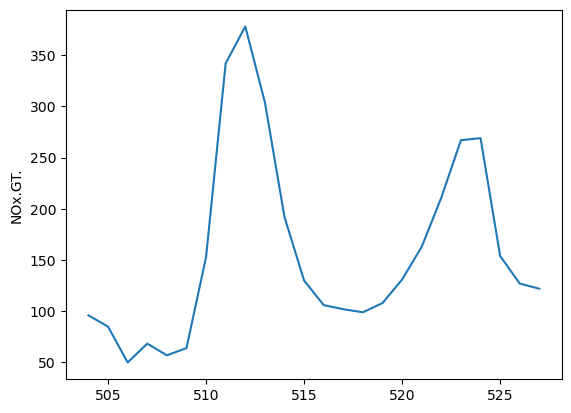

In [138]:
sns.lineplot(test)

In [139]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """

    # Generate a TF Dataset from the series values: this creates a TF dataset with each value of the series as a tensor
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size; this creates given [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    #if window_size is 1 something like; IMPORTANT this resemblance is given after the flat_map 
    #[1, 2, 3, 4]
    #[2, 3, 4, 5]
    #[3, 4, 5, 6]
    #[4, 5, 6, 7]
    #[5, 6, 7, 8]
    #[6, 7, 8, 9]
    #[7, 8, 9, 10]
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels: X and Y respectively
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows; it basically takes the X,Y pairs and resample them
    dataset = dataset.shuffle(shuffle_buffer)

    # Create batches of windows; here given the resampled dataset it creates small groups given by batch_size; for example something
    #like; batch_size 2 with the showed example
    #Features: [[8 9 10] [12 13 14]] Label: [11 15]
    #Features: [[7 8 9] [13 14 15]] Label: [10 16]
    #Features: [[3 4 5] [14 15 16]] Label: [6 17]
    #Features: [[9 10 11] [15 16 17]] Label: [12 18]
    #Features: [[10 11 12] [16 17 18]] Label: [13 19]
    #Features: [[2 3 4] [11 12 13]] Label: [5 14]
    #Features: [[6 7 8] [17 18 19]] Label: [9 20]
    #Features: [[5 6 7] [1 2 3]] Label: [8 4]
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset

In [140]:
# Parameters
window_size = 24
batch_size = 64
shuffle_buffer_size = int(len(train)*0.75)

# Generate the dataset windows
train_set = windowed_dataset(train, window_size, batch_size, shuffle_buffer_size)

### Forecasting with a DNN 

In [141]:
# Build the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(24, input_shape=[window_size], activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

In [142]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 0s 4ms/step - loss: 70.0274 - lr: 1.0000e-08
Epoch 2/100
8/8 [==============================] - 0s 1ms/step - loss: 70.0016 - lr: 1.1220e-08
Epoch 3/100
8/8 [==============================] - 0s 1ms/step - loss: 69.9596 - lr: 1.2589e-08
Epoch 4/100
8/8 [==============================] - 0s 1ms/step - loss: 69.9072 - lr: 1.4125e-08
Epoch 5/100
8/8 [==============================] - 0s 1ms/step - loss: 69.8485 - lr: 1.5849e-08
Epoch 6/100
8/8 [==============================] - 0s 1ms/step - loss: 69.7803 - lr: 1.7783e-08
Epoch 7/100
8/8 [==============================] - 0s 1ms/step - loss: 69.7078 - lr: 1.9953e-08
Epoch 8/100
8/8 [==============================] - 0s 1ms/step - loss: 69.6120 - lr: 2.2387e-08
Epoch 9/100
8/8 [==============================] - 0s 1ms/step - loss: 69.5170 - lr: 2.5119e-08
Epoch 10/100
8/8 [==============================] - 0s 1ms/step - loss: 69.4097 - lr: 2.8184e-08
Epoch 11/100
8/8 [=====================

(1e-08, 0.001, 0.0, 100.0)

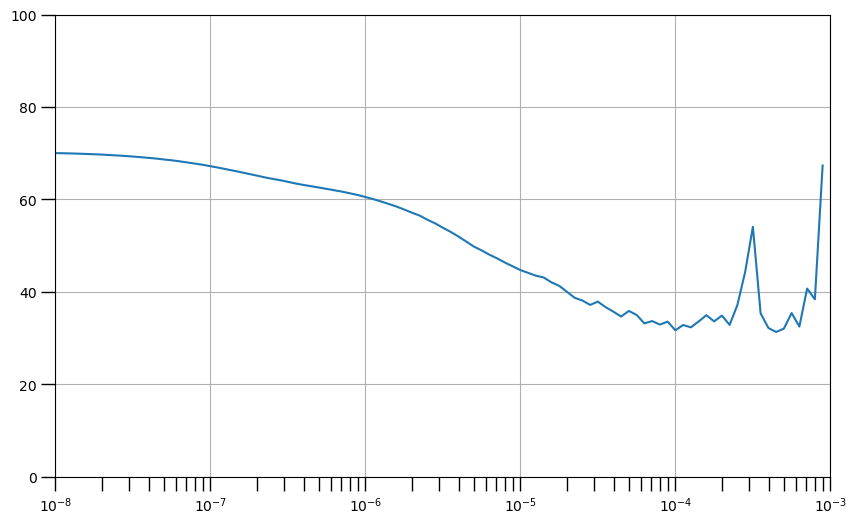

In [143]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 100])

In [144]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Build the Model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(24, input_shape=[window_size], activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

In [ ]:
early_stopping = EarlyStopping(
    patience=20,
    min_delta=0.001,
    restore_best_weights=True,
    monitor='mae',  # Monitor validation MAE
    mode='min',  # Mode can be 'min' or 'max' depending on the metric to minimize or maximize
    verbose=1  # Display messages when early stopping
)

In [159]:
model_checkpoint1 = ModelCheckpoint(
    'deepModel.h5',  # Save the best weights to this file
    save_best_only=True,  # Only save the best weights based on the validation MAE
    monitor='mae',  # Monitor validation MAE
    mode='min',  # Mode can be 'min' or 'max' depending on the metric to minimize or maximize
    verbose=1  # Display messages when saving the best weights
)

In [160]:
# Set the learning rate
learning_rate = 5e-4

# Set the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(train_set,epochs=100,batch_size=64,callbacks=[early_stopping,model_checkpoint1])

Epoch 1/100
      1/Unknown - 0s 345ms/step - loss: 37.4428 - mae: 37.9427
Epoch 1: mae improved from inf to 38.70831, saving model to deepModel.h5
8/8 [==============================] - 0s 8ms/step - loss: 38.2149 - mae: 38.7083
Epoch 2/100
1/8 [==>...........................] - ETA: 0s - loss: 49.1905 - mae: 49.6804
Epoch 2: mae did not improve from 38.70831
8/8 [==============================] - 0s 1ms/step - loss: 44.2105 - mae: 44.7064
Epoch 3/100
1/8 [==>...........................] - ETA: 0s - loss: 43.7745 - mae: 44.2745
Epoch 3: mae did not improve from 38.70831
8/8 [==============================] - 0s 1ms/step - loss: 46.4996 - mae: 46.9970
Epoch 4/100
1/8 [==>...........................] - ETA: 0s - loss: 47.0584 - mae: 47.5584
Epoch 4: mae improved from 38.70831 to 38.39186, saving model to deepModel.h5


C:\Users\mueco\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


8/8 [==============================] - 0s 4ms/step - loss: 37.8943 - mae: 38.3919
Epoch 5/100
1/8 [==>...........................] - ETA: 0s - loss: 57.2756 - mae: 57.7721
Epoch 5: mae improved from 38.39186 to 36.32609, saving model to deepModel.h5
8/8 [==============================] - 0s 4ms/step - loss: 35.8326 - mae: 36.3261
Epoch 6/100
1/8 [==>...........................] - ETA: 0s - loss: 38.6575 - mae: 39.1575
Epoch 6: mae improved from 36.32609 to 34.68349, saving model to deepModel.h5
8/8 [==============================] - 0s 4ms/step - loss: 34.1875 - mae: 34.6835
Epoch 7/100
1/8 [==>...........................] - ETA: 0s - loss: 31.8748 - mae: 32.3746
Epoch 7: mae did not improve from 34.68349
8/8 [==============================] - 0s 1ms/step - loss: 43.0111 - mae: 43.5097
Epoch 8/100
1/8 [==>...........................] - ETA: 0s - loss: 29.9871 - mae: 30.4758
Epoch 8: mae did not improve from 34.68349
8/8 [==============================] - 0s 1ms/step - loss: 37.5602 - m

Epoch 41/100
1/8 [==>...........................] - ETA: 0s - loss: 22.6749 - mae: 23.1706
Epoch 41: mae did not improve from 27.51942
8/8 [==============================] - 0s 1ms/step - loss: 29.2913 - mae: 29.7859
Epoch 42/100
1/8 [==>...........................] - ETA: 0s - loss: 26.2125 - mae: 26.7007
Epoch 42: mae did not improve from 27.51942
8/8 [==============================] - 0s 1ms/step - loss: 27.1147 - mae: 27.6105
Epoch 43/100
1/8 [==>...........................] - ETA: 0s - loss: 24.4748 - mae: 24.9697
Epoch 43: mae did not improve from 27.51942
8/8 [==============================] - 0s 1ms/step - loss: 27.1701 - mae: 27.6628
Epoch 44/100
1/8 [==>...........................] - ETA: 0s - loss: 28.6069 - mae: 29.1069
Epoch 44: mae improved from 27.51942 to 27.40145, saving model to deepModel.h5
8/8 [==============================] - 0s 3ms/step - loss: 26.9059 - mae: 27.4014
Epoch 45/100
1/8 [==>...........................] - ETA: 0s - loss: 38.8487 - mae: 39.3469
Epoch 

In [161]:
history_frame = pd.DataFrame(history.history)

<Axes: >

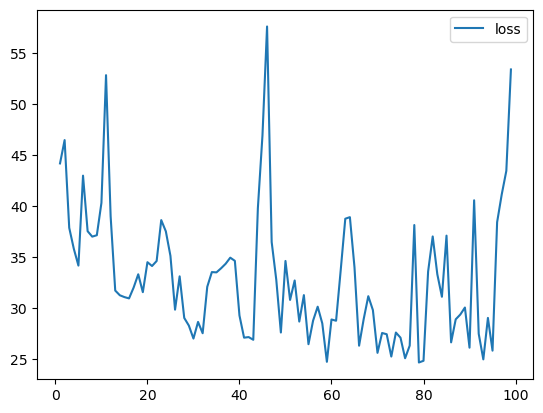

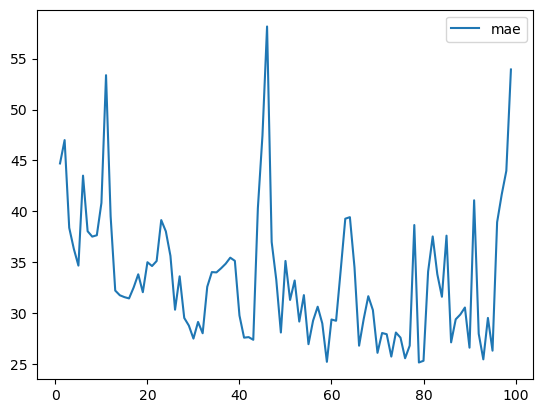

In [162]:
history_frame.loc[1:, ['loss']].plot()
history_frame.loc[1:, ['mae']].plot()

In [163]:
best_model1 = keras.models.load_model('deepModel.h5')

In [164]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    # Get predictions on the entire dataset
    forecast = model.predict(dataset)

    return forecast

In [165]:
# Reduce the original series
series = data[504-24:527]

forecast_series = series['NOx.GT.']

# Use helper function to generate predictions
forecast = model_forecast(best_model1, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

1/1 [==============================] - 0s 54ms/step


<Axes: ylabel='NOx.GT.'>

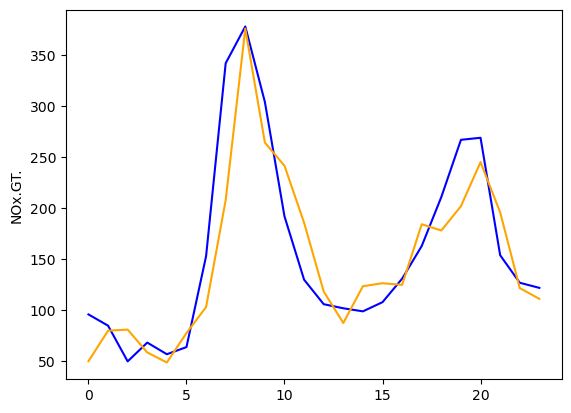

In [166]:
sns.lineplot(x=range(len(test)),y=test,color='blue')
sns.lineplot(x=range(len(results)),y=results,color='orange')

In [167]:
print(tf.keras.metrics.mean_absolute_error(test, results).numpy())

30.059143


### Forecasting with CNN and RNN

In [156]:
# Build the Model
model2 = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                      strides=1,
                      activation="relu",
                      padding='causal',
                      input_shape=[window_size, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64),
  tf.keras.layers.Dense(24, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

In [157]:
# Get initial weights
init_weights = model2.get_weights()

In [158]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model2.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model2.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 2s 16ms/step - loss: 252.6801 - lr: 1.0000e-08
Epoch 2/100
8/8 [==============================] - 0s 13ms/step - loss: 245.1107 - lr: 1.1220e-08
Epoch 3/100
8/8 [==============================] - 0s 13ms/step - loss: 231.0115 - lr: 1.2589e-08
Epoch 4/100
8/8 [==============================] - 0s 13ms/step - loss: 214.9333 - lr: 1.4125e-08
Epoch 5/100
8/8 [==============================] - 0s 13ms/step - loss: 202.0799 - lr: 1.5849e-08
Epoch 6/100
8/8 [==============================] - 0s 13ms/step - loss: 190.7657 - lr: 1.7783e-08
Epoch 7/100
8/8 [==============================] - 0s 13ms/step - loss: 179.3906 - lr: 1.9953e-08
Epoch 8/100
8/8 [==============================] - 0s 13ms/step - loss: 168.4079 - lr: 2.2387e-08
Epoch 9/100
8/8 [==============================] - 0s 13ms/step - loss: 158.9133 - lr: 2.5119e-08
Epoch 10/100
8/8 [==============================] - 0s 13ms/step - loss: 151.4561 - lr: 2.8184e-08
Epoch 11/100
8/8 [=

(1e-08, 0.001, 0.0, 100.0)

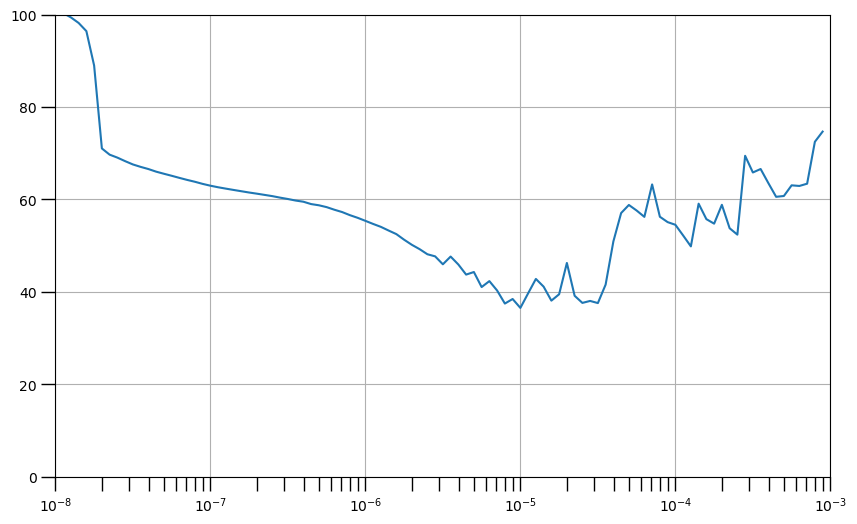

In [122]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 100])

In [170]:
model_checkpoint2 = ModelCheckpoint(
    'CNNLSTMModel.h5',  # Save the best weights to this file
    save_best_only=True,  # Only save the best weights based on the validation MAE
    monitor='mae',  # Monitor validation MAE
    mode='min',  # Mode can be 'min' or 'max' depending on the metric to minimize or maximize
    verbose=1  # Display messages when saving the best weights
)

In [171]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Reset the weights
model2.set_weights(init_weights)
# Set the learning rate
learning_rate = 5e-6

# Set the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model2.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
# Train the model
history = model2.fit(train_set,epochs=100,batch_size=64,callbacks=[early_stopping,model_checkpoint2])

Epoch 1/100
      5/Unknown - 3s 14ms/step - loss: 165.7540 - mae: 166.2540
Epoch 1: mae improved from inf to 136.95364, saving model to CNNLSTMModel.h5
8/8 [==============================] - 3s 22ms/step - loss: 136.4546 - mae: 136.9536
Epoch 2/100
5/8 [=================>............] - ETA: 0s - loss: 61.9078 - mae: 62.4061
Epoch 2: mae improved from 136.95364 to 61.37474, saving model to CNNLSTMModel.h5


C:\Users\mueco\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


8/8 [==============================] - 0s 20ms/step - loss: 60.8769 - mae: 61.3747
Epoch 3/100
5/8 [=================>............] - ETA: 0s - loss: 53.8552 - mae: 54.3522
Epoch 3: mae improved from 61.37474 to 57.11389, saving model to CNNLSTMModel.h5
8/8 [==============================] - 0s 19ms/step - loss: 56.6164 - mae: 57.1139
Epoch 4/100
5/8 [=================>............] - ETA: 0s - loss: 56.3016 - mae: 56.7989
Epoch 4: mae improved from 57.11389 to 54.58180, saving model to CNNLSTMModel.h5
8/8 [==============================] - 0s 20ms/step - loss: 54.0843 - mae: 54.5818
Epoch 5/100
5/8 [=================>............] - ETA: 0s - loss: 50.9661 - mae: 51.4657
Epoch 5: mae improved from 54.58180 to 51.05959, saving model to CNNLSTMModel.h5
8/8 [==============================] - 0s 20ms/step - loss: 50.5599 - mae: 51.0596
Epoch 6/100
5/8 [=================>............] - ETA: 0s - loss: 47.0969 - mae: 47.5952
Epoch 6: mae improved from 51.05959 to 47.79338, saving model to 

Epoch 38/100
5/8 [=================>............] - ETA: 0s - loss: 37.8198 - mae: 38.3178
Epoch 38: mae did not improve from 33.56844
8/8 [==============================] - 0s 14ms/step - loss: 36.7882 - mae: 37.2859
Epoch 39/100
5/8 [=================>............] - ETA: 0s - loss: 34.6329 - mae: 35.1294
Epoch 39: mae did not improve from 33.56844
8/8 [==============================] - 0s 16ms/step - loss: 35.1719 - mae: 35.6672
Epoch 40/100
5/8 [=================>............] - ETA: 0s - loss: 32.1090 - mae: 32.6049
Epoch 40: mae did not improve from 33.56844
8/8 [==============================] - 0s 15ms/step - loss: 35.5687 - mae: 36.0660
Epoch 41/100
5/8 [=================>............] - ETA: 0s - loss: 36.1088 - mae: 36.6058
Epoch 41: mae did not improve from 33.56844
8/8 [==============================] - 0s 16ms/step - loss: 37.3864 - mae: 37.8843
Epoch 42/100
5/8 [=================>............] - ETA: 0s - loss: 35.0088 - mae: 35.5062
Epoch 42: mae did not improve from 33

<Axes: >

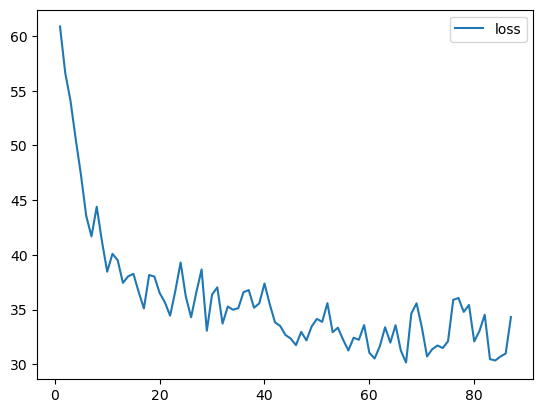

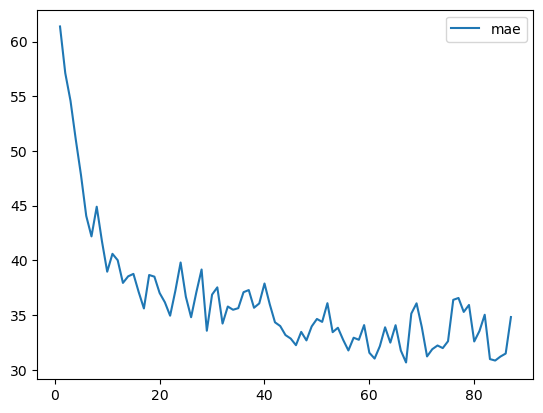

In [172]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[1:, ['loss']].plot()
history_frame.loc[1:, ['mae']].plot()

In [173]:
best_model2 = keras.models.load_model('CNNLSTMModel.h5')

In [174]:
# Use helper function to generate predictions
forecast = model_forecast(best_model2, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results2 = forecast.squeeze()

1/1 [==============================] - 1s 541ms/step


<Axes: ylabel='NOx.GT.'>

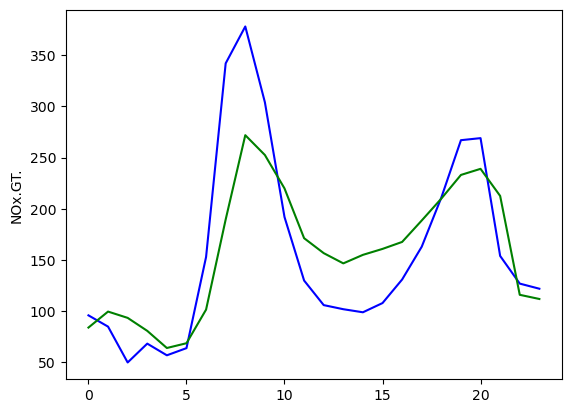

In [175]:
sns.lineplot(x=range(len(test)),y=test,color='blue')
sns.lineplot(x=range(len(results2)),y=results2,color='green')

In [176]:
# Compute the MAE
print(tf.keras.metrics.mean_absolute_error(test, results2).numpy())

39.012115


### Comparative 

<Axes: ylabel='NOx.GT.'>

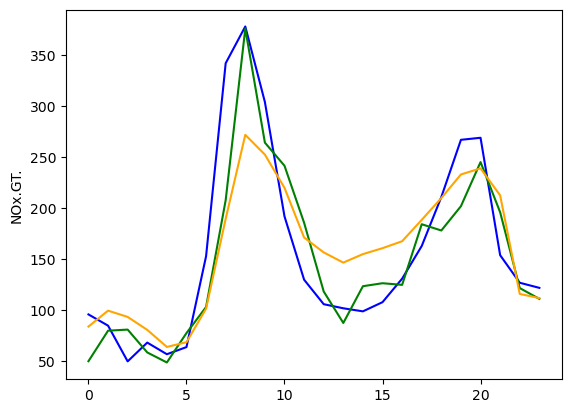

In [177]:
sns.lineplot(x=range(len(test)),y=test,color='blue')
sns.lineplot(x=range(len(results)),y=results,color='green')
sns.lineplot(x=range(len(results2)),y=results2,color='orange')